Programa escrito para testar as funções de cálculo de volume de ar nos pulmões, para ser usado como volume de referência no cálculo de potencial de recrutamento alveolar.

Testado com MRA_29.

Segmentação completa (incluindo colapso) não funciona com CTs volumétricas, pela dificuldade de separar diagrafma e coração do colapso (valores HU próximos).

In [1]:
import ctFuncs as ctf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# inclui funções para fitar curvas:
import sys
sys.path.insert(0,'/dados/github/projetos/recrutabilidade')
import modelos as m

In [3]:
%load_ext autoreload
%autoreload 2

In [51]:
pasta_figuras_texto = '/mnt/hdsda3/arquivos/Recrutamento/figuras/texto/'

# Lendo imagens

In [4]:
pasta = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_29/Recrut_pos/Vol_Recru_Pos_50_mm_10'    # CT volumetrica

In [5]:
imagens = ctf.lePastaDICOM(pasta)

Size: (512, 512, 89); Spacing: (0.68359375, 0.68359375, 5.0)


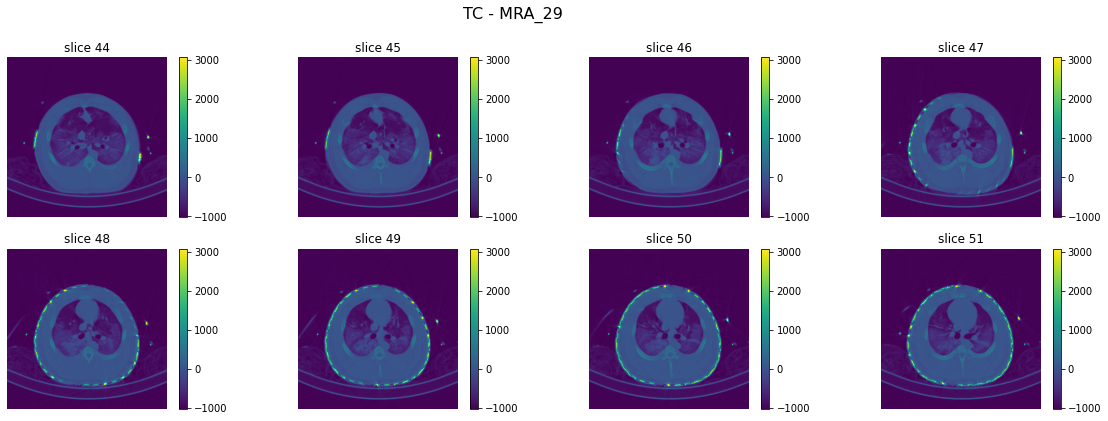

In [52]:
fig = ctf.mostraCortesDICOM(imagens,44,8,colorbar=True)
_= fig.suptitle('TC - MRA_29', fontsize=16, y=0.95)
fig.savefig(pasta_figuras_texto+'ct_mra29.pdf',bbox_inches='tight')

# Segmentando pulmão

In [7]:
### Exemplo de código segmentando pulmão aerado:
# df = ctf.SegmentaPulmaoAerado(imagens)              # segmenta pulmao aerado
# _= ctf.mostraCortes(df.imagem.values,0,4)           # mostra imagens de ct completas
# _= ctf.mostraCortes(df.mascara_aerado.values,0,4)   # mostra mascaras do pulmao aerado
# plt.imshow(df.imagem.values[0])                     # mostra apenas um corte

In [8]:
df = ctf.SegmentaPulmaoCompleto(imagens, threshold=50)  # threshold para pulmão totalmente recrutado

In [9]:
df.head(3)

,imagem,mascara_ar,imagem_ar,pulmao,imagem_pulmao
0,"[[-1003, -991, -1000, -1006, -992, -999, -1015...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[-1015, -1000, -998, -1003, -1002, -995, -999...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[-987, -994, -1009, -1012, -1004, -1006, -100...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [10]:
## PARA INVESTIGAR...
#import SimpleITK as sitk
#img_aux = imagens[:,:,1]
#img_aux = sitk.GetImageFromArray(sitk.GetArrayFromImage(img_aux)) # sem isso não funciona!!!
#mask_pulmao_completo = ctf.SegmentaPulmaoCompletoImg(img_aux, threshold=50) # threshold para pulmão totalmente recrutado
#plt.imshow(ctf.I2A(mask_pulmao_completo))

#temp2 = ctf.I2A(imagens)
#print(f'Cuidado! Índices invertidos: {temp2[88][214,245]} = {imagens[245,214,88]}')

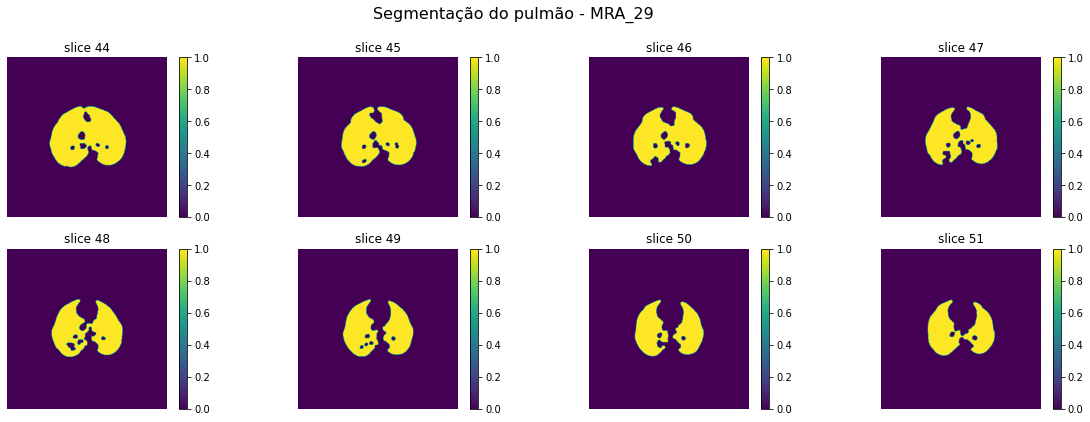

In [53]:
fig = ctf.mostraCortes(df.pulmao.values,44,8,colorbar=True)
_= fig.suptitle('Segmentação do pulmão - MRA_29', fontsize=16, y=0.95)
fig.savefig(pasta_figuras_texto+'ct_mra29_mask.pdf',bbox_inches='tight')

In [12]:
import SimpleITK as sitk 
type(df.imagem_pulmao.values)

numpy.ndarray

In [13]:
minha_mask = (np.dstack(df.imagem_pulmao.values) < 0)
type(minha_mask)

numpy.ndarray

In [14]:
imagens_pulmao = np.dstack(df.imagem_pulmao.values) * minha_mask

In [15]:
imagens_pulmao_new = np.stack(np.stack(imagens_pulmao,axis=2).T,axis=1)

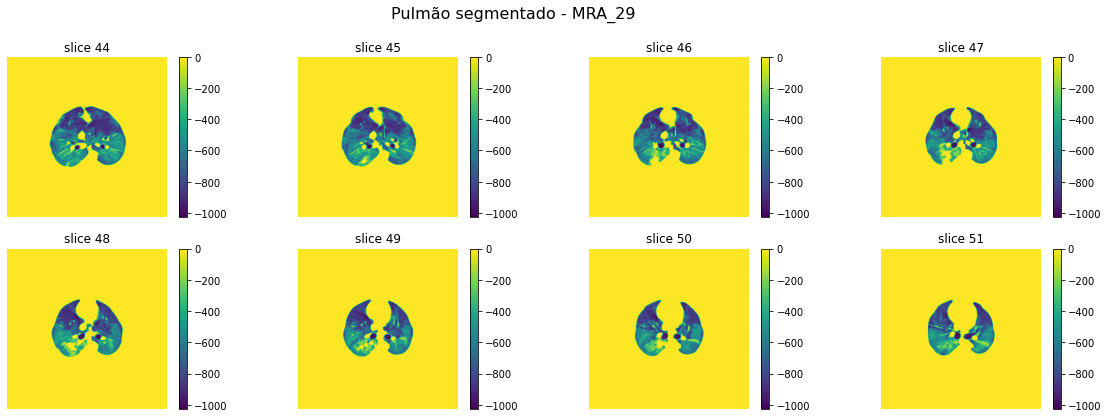

In [54]:
fig = ctf.mostraCortes(imagens_pulmao_new,44,8,colorbar=True)
_= fig.suptitle('Pulmão segmentado - MRA_29', fontsize=16, y=0.95)
fig.savefig(pasta_figuras_texto+'ct_mra29_lung.pdf',bbox_inches='tight')

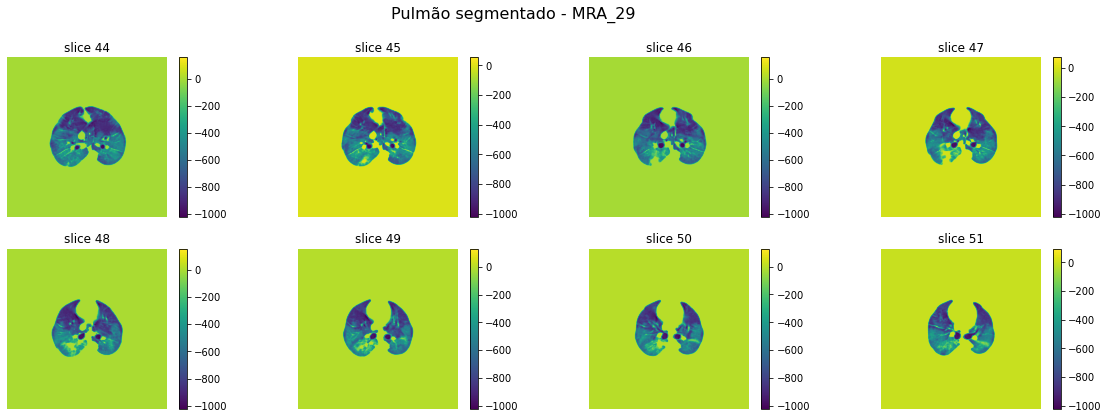

In [17]:
fig = ctf.mostraCortes(df.imagem_pulmao.values,44,8,colorbar=True)
_= fig.suptitle('Pulmão segmentado - MRA_29', fontsize=16, y=0.95)

# Calculando volume de ar

In [18]:
v_voxel_mL = np.prod(imagens.GetSpacing())/1000
volume_ar = ctf.calcula_volume_ar(df.imagem_pulmao.values,v_voxel_mL)
print(f'{volume_ar} mL')

1678.5440254211426 mL


# Verificando funções quando existe colapso

## MRA29 D1

Size: (512, 512, 86); Spacing: (0.68359375, 0.68359375, 5.000000000000001)
500.71549525260934 mL


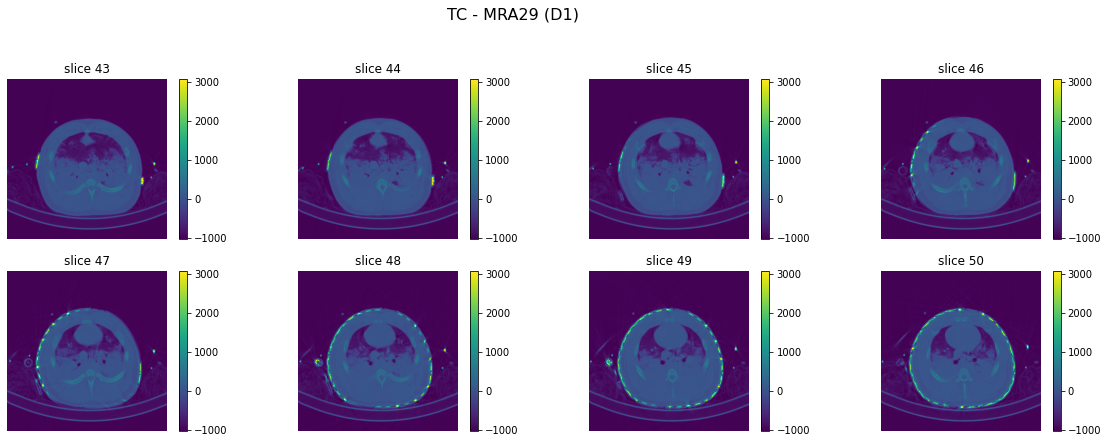

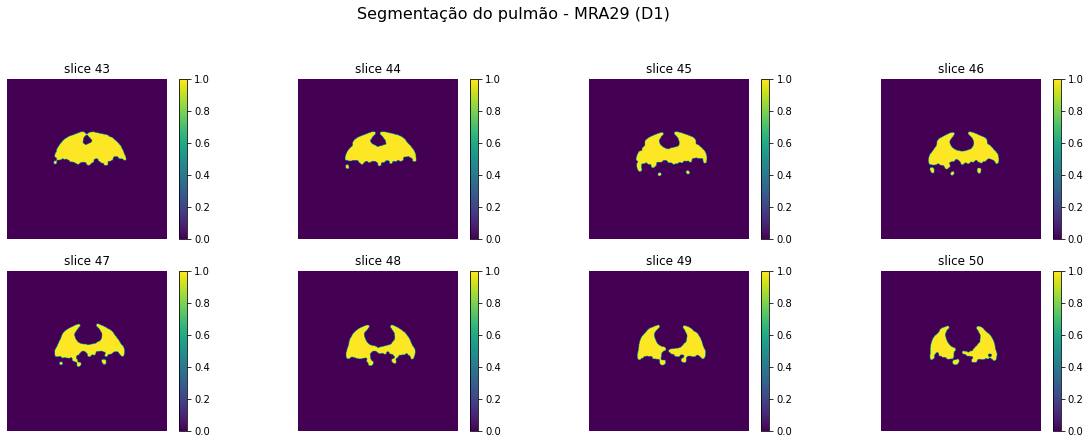

In [19]:
pasta_D1 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_29/D/Vol_Int_D1_10_50_mm_2'    # CT volumetrica
volume_ar_D1,imagens_D1,df_D1 = ctf.calcula_volume_pasta(pasta_D1, animal='MRA29 (D1)', mostraImagens = True)

## D5

In [20]:
pasta_D5 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_29/D/Vol_Int_D5_30_50_mm_6'    # CT volumetrica

In [21]:
_ = ctf.calcula_volume_pasta(pasta_D5, animal='MRA29 (D5)')

Size: (512, 512, 86); Spacing: (0.68359375, 0.68359375, 5.000000000000001)
1305.5184970855717 mL


## B1

In [22]:
pasta_B1 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_29/B/Vol_B1_10_50_mm_2'    # CT volumetrica
_ = ctf.calcula_volume_pasta(pasta_B1, animal='MRA29 (B1)')

Size: (512, 512, 88); Spacing: (0.68359375, 0.68359375, 5.0)
531.2288735389709 mL


# Outros testes

Teste de segmentação completa do pulmão, incluindo parte colapsada.
Aparentemente não funciona com CT volumétrica, pela dificuldade de separar coração e diafragma da parte colapsada (valores HU similares).

Size: (512, 512, 86); Spacing: (0.68359375, 0.68359375, 5.000000000000001)
500.71549525260934 mL


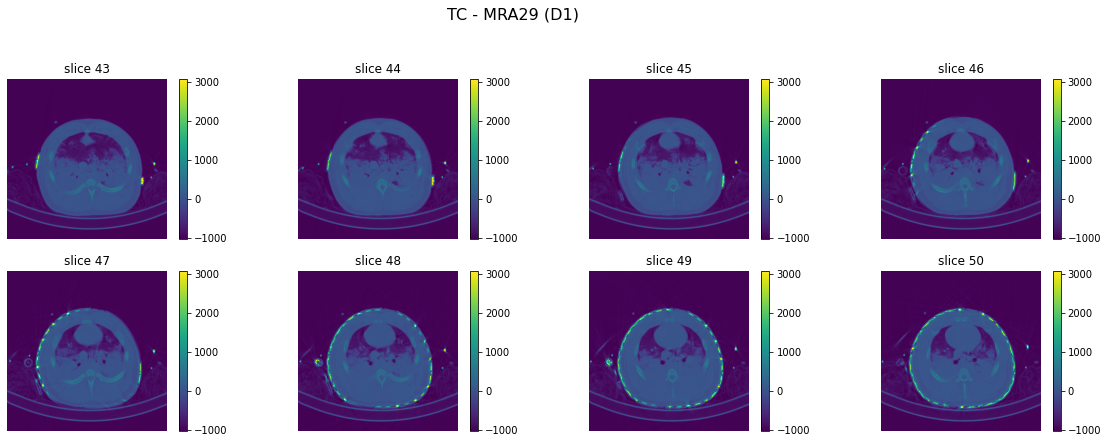

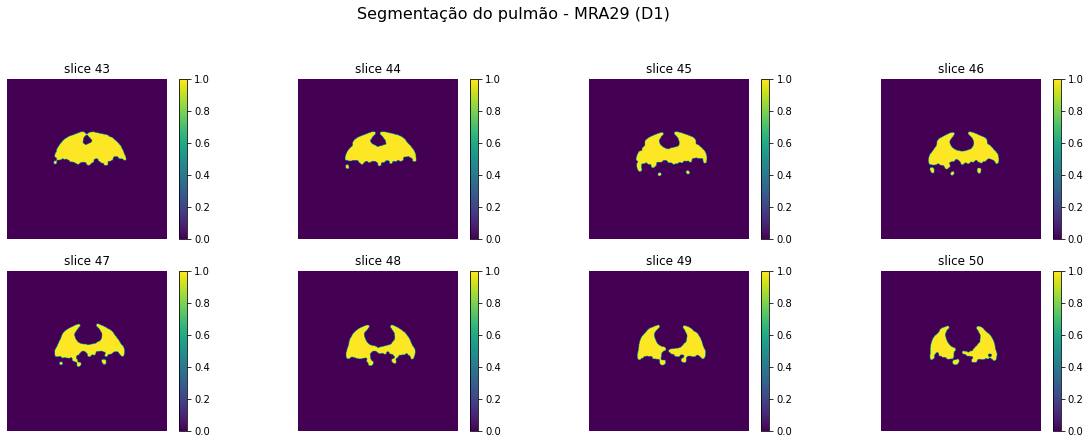

In [23]:
pasta_D1 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_29/D/Vol_Int_D1_10_50_mm_2'    # CT volumetrica
volume_ar_D1,imagens_D1,df_D1 = ctf.calcula_volume_pasta(pasta_D1, animal='MRA29 (D1)', mostraImagens = True)

In [24]:
# FUNÇÃO NÃO FINALIZADA...
#_= ctf.SegmentaPulmaoCompleto3D(imagens_D1)

<br/><br/><br/><br/><br/><br/>
# Ajuste da exponencial nos volumes recrutados

## MRA29 pós recrutamento (PEEP 24cmH2O)

In [25]:
pasta = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_29/Recrut_pos/Vol_Recru_Pos_50_mm_10'    # CT volumetrica
volume_ar_MRA29_RP,imagens_MRA29_RP,df_MRA29_RP = ctf.calcula_volume_pasta(pasta, animal='MRA29 (pós recrutamento - PEEP 24 cmH2O)')

Size: (512, 512, 89); Spacing: (0.68359375, 0.68359375, 5.0)
1678.5440254211426 mL


## MRA29 durante recrutamento fase 3 (PEEP 45cmH2O)

In [26]:
pasta = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_29/Recrut_pos/Vol_Recru_3_50_mm_8'    # CT volumetrica
volume_ar_MRA29_R3,imagens_MRA29_R3,df_MRA29_R3 = ctf.calcula_volume_pasta(pasta, animal='MRA29 (durante recrutamento - PEEP 40 cmH2O)')

Size: (512, 512, 89); Spacing: (0.68359375, 0.68359375, 5.0)
2055.0341540813447 mL


# Todos os TLCs estimados

## MRA26

Size: (512, 512, 87); Spacing: (0.765625, 0.765625, 5.0)
1373.4339242285157 mL
Size: (512, 512, 87); Spacing: (0.765625, 0.765625, 5.0)
1969.8752383276367 mL
K = 0.030899094057260833; Vmax = 2622.866589297819


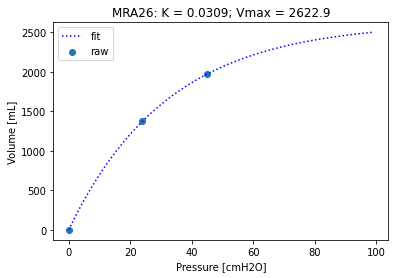

In [27]:
pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_26/Recrut_pos/RECRUT_3_5_0_MM_0005'    # CTvol 1969 mL
pasta_pos = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_26/Recrut_pos/POS_RECRUT3_5_0_MM_0006'    # CTvol 1373 mL
_= ctf.ajusta_exponencial_recrutamento(pasta_pos, pasta_R3, 'MRA26')

## MRA28

Size: (512, 512, 90); Spacing: (0.68359375, 0.68359375, 5.000000000000001)
1384.9271159648897 mL
Size: (512, 512, 90); Spacing: (0.68359375, 0.68359375, 5.000000000000001)
1823.6774616718296 mL
K = 0.044662472791196964; Vmax = 2105.897076663757


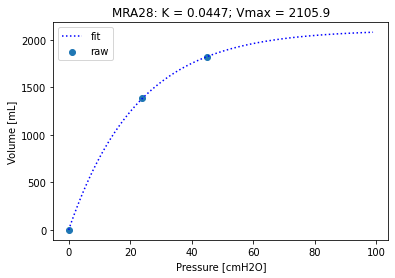

In [28]:
#pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/Recrut_pos/Vol_Recru_1_50_mm_4'    # CTvol 1210 mL
#pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/Recrut_pos/Vol_Recru_2_50_mm_6'    # CTvol 1314 mL
#pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/Recrut_pos/Vol_Recru_3_2_mm_10'    # CTvol 1385 mL
pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/Recrut_pos/Vol_Recru_3_50_mm_8'     # CTvol 1384 mL

pasta_pos = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/Recrut_pos/Vol_Recru_36_50_mm_9'    # CTvol 1823 mL
#pasta_pos = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/Recrut_pos/Vol_Recru_Pos_2_mm_13'    # CTvol 1437 mL
#pasta_pos = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/Recrut_pos/Vol_Recru_Pos_50_mm_11'    # CTvol 1436 mL

#_= ctf.ajusta_exponencial_recrutamento(pasta_pos, pasta_R3, 'MRA28')
_= ctf.ajusta_exponencial_recrutamento(pasta_R3, pasta_pos, 'MRA28')
#_= ctf.ajusta_exponencial_recrutamento(pasta_R3, pasta_pos, 'MRA28', pressoes = [0, 24, 36]) # só para verificação, não é 36...

## MRA29

Size: (512, 512, 89); Spacing: (0.68359375, 0.68359375, 5.0)
1678.5440254211426 mL
Size: (512, 512, 89); Spacing: (0.68359375, 0.68359375, 5.0)
2055.0341540813447 mL
K = 0.05963694133068645; Vmax = 2205.711869226343


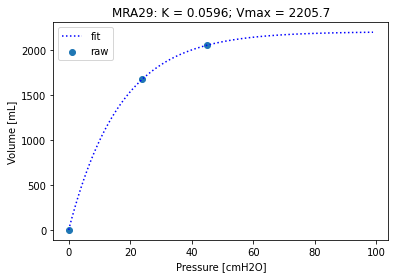

In [29]:
pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_29/Recrut_pos/Vol_Recru_3_50_mm_8'    # CTvol 2055 mL
pasta_pos = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_29/Recrut_pos/Vol_Recru_Pos_50_mm_10'    # CTvol 1678 mL
_= ctf.ajusta_exponencial_recrutamento(pasta_pos, pasta_R3, 'MRA29')

## MRA31

Size: (512, 512, 76); Spacing: (0.65625, 0.65625, 5.0)
1527.71957296875 mL
Size: (512, 512, 76); Spacing: (0.65625, 0.65625, 5.0)
1852.7079208886719 mL
K = 0.06192490498562224; Vmax = 1974.3877060910486


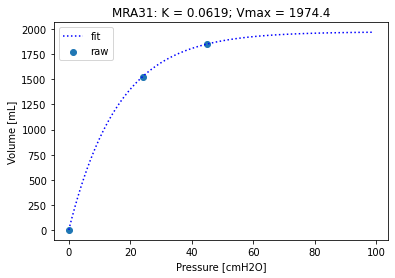

In [30]:
pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_31/Recrut_pos/Vol_Recru_3_50_mm_7'       # CTvol 1852 mL
pasta_pos = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_31/Recrut_pos/Vol_Recru_Pos_50_mm_8'    # CTvol 1527 mL
_= ctf.ajusta_exponencial_recrutamento(pasta_pos, pasta_R3, 'MRA31')

## MRA32

Size: (512, 512, 84); Spacing: (0.68359375, 0.68359375, 5.0)
981.0712067604064 mL
Size: (512, 512, 84); Spacing: (0.68359375, 0.68359375, 5.0)
1271.3319202423095 mL
K = 0.047635948526718166; Vmax = 1440.162083889477


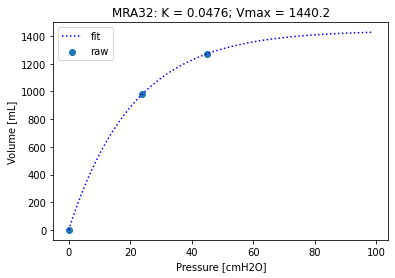

In [31]:
#pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_32/Recrut_pos/Vol_Recru_1_50_mm_3'       # CTvol 725 mL
#pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_32/Recrut_pos/Vol_Recru_2_50_mm_4'       # CTvol 780 mL
#pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_32/Recrut_pos/Vol_Recru_3_50_mm_5'       # CTvol 860 mL
pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_32/Recrut_pos/Vol_Recru_3_50_mm_10'       # CTvol 1271 mL

pasta_pos = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_32/Recrut_pos/Vol_Recru_Pos_50_mm_11'    # CTvol 981 mL
_= ctf.ajusta_exponencial_recrutamento(pasta_pos, pasta_R3, 'MRA32')

## MRA33

Size: (512, 512, 84); Spacing: (0.796875, 0.796875, 5.0)
1684.4333432958988 mL
Size: (512, 512, 84); Spacing: (0.796875, 0.796875, 5.0)
2030.4792702575683 mL
K = 0.0634304706003319; Vmax = 2154.5650333633625


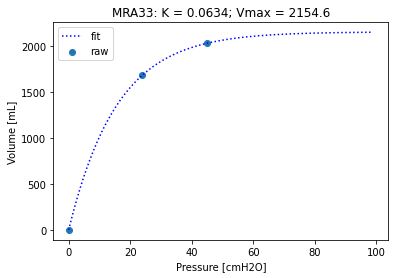

In [32]:
pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_33/Recrut_pos/Vol_Recru_3_50_mm_8'       # CTvol 2030 mL
pasta_pos = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_33/Recrut_pos/Vol_Recru_Pos_50_mm_10'    # CTvol 1684 mL
_= ctf.ajusta_exponencial_recrutamento(pasta_pos, pasta_R3, 'MRA33')

## MRA34

Size: (512, 512, 79); Spacing: (0.623046875, 0.623046875, 5.0)
1612.423954714756 mL
Size: (512, 512, 79); Spacing: (0.623046875, 0.623046875, 5.0)
2020.3082057697106 mL
K = 0.054431870388412865; Vmax = 2211.231283753174


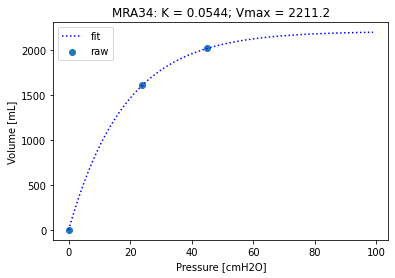

In [33]:
pasta_pos = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_34/Recrut_pos/Vol_Recru_Pos_50_mm_10'    # CTvol 1684 mL
pasta_R3 = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_34/Recrut_pos/Vol_Recru_3_50_mm_8'       # CTvol 2030 mL
_= ctf.ajusta_exponencial_recrutamento(pasta_pos, pasta_R3, 'MRA34')

# Recrutabilidade nas CTs

## Dados das CTs

In [43]:
mra_lst = []

pasta = '/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/'

mra = ctf.dadosCts()
mra.nome = 'mra26'
mra.CTs = [pasta+'MRA_26/B/POS_B_5_0_MM_0019',
           pasta+'MRA_26/D/POS_D5_5_0_MM_0008',
           pasta+'MRA_26/Recrut_pos/RECRUT_3_5_0_MM_0005']     ### poucos dados...
mra.peeps =   [      10,       30, 45]
mra.pressoes = [  10.25,   30.463, 45]
mra.volumes = [1367.135, 1944.058, 2571.724] # da tabela da Roberta 
mra.CTs_rec = [pasta+'MRA_26/Recrut_pos/POS_RECRUT3_5_0_MM_0006',    # CTvol 1373 mL
               pasta+'MRA_26/Recrut_pos/RECRUT_3_5_0_MM_0005']       # CTvol 1969 mL
mra_lst.append(mra)

mra = ctf.dadosCts()
mra.nome = 'mra28'
mra.CTs = [pasta+'MRA_28/B/Vol_B1_10_50_mm_2',
           pasta+'MRA_28/B/Vol_B3_20_50_mm_4',
           pasta+'MRA_28/C/Vol_C4_25_50_mm_6',
           pasta+'MRA_28/D/Vol_Int_D5_30_50_mm_6',
           pasta+'MRA_28/Recrut_pos/Vol_Recru_36_50_mm_9']
mra.peeps =    [     10,       20,       25,       30,       45]
mra.pressoes = [ 10.022,   20.012,   25.478,   29.956,       45]
mra.volumes = [1283.233, 1660.177, 1847.163, 2051.841, 2076.818] # da tabela da Roberta ### v(45) parece subestimado...
mra.CTs_rec = [pasta+'MRA_28/Recrut_pos/Vol_Recru_3_50_mm_8',       # CTvol 1384 mL
               pasta+'MRA_28/Recrut_pos/Vol_Recru_36_50_mm_9']      # CTvol 1823 mL
mra_lst.append(mra)

mra = ctf.dadosCts()
mra.nome = 'mra29'
mra.CTs = [pasta+'MRA_29/B/Vol_B1_10_50_mm_2',
           pasta+'MRA_29/B/Vol_B3_20_50_mm_4',
           pasta+'MRA_29/C/Vol_C4_25_50_mm_6',
           pasta+'MRA_29/D/Vol_Int_D5_30_50_mm_6',
           pasta+'MRA_29/Recrut_pos/Vol_Recru_3_50_mm_8']
mra.peeps =    [     10,       20,       25,      30,      45]
mra.pressoes = [ 10.261,   20.030,   25.017,  30.088,      45]
mra.volumes = [1500.447, 1878.034, 2151.105, 2277.27, 2840.79] # da tabela da Roberta
mra.CTs_rec = [pasta+'MRA_29/Recrut_pos/Vol_Recru_Pos_50_mm_10',     # CTvol 1678 mL
               pasta+'MRA_29/Recrut_pos/Vol_Recru_3_50_mm_8']        # CTvol 2055 mL
mra_lst.append(mra)

mra = ctf.dadosCts()
mra.nome = 'mra31'
mra.CTs = [pasta+'MRA_31/B/Vol_B1_10_50_mm_2',
           pasta+'MRA_31/B/Vol_B3_20_50_mm_4',
           pasta+'MRA_31/C/Vol_C4_25_50_mm_5',
           pasta+'MRA_31/D/Vol_Int_D5_30_50_mm_6',
           pasta+'MRA_31/Recrut_pos/Vol_Recru_3_50_mm_7']
mra.peeps =    [     10,       20,       25,      30,       45]
mra.pressoes = [ 10.300,   19.900,   25.000,  30.200,       45]
mra.volumes = [1402.213, 1627.787, 1843.926, 1883.24, 2600.757] # da tabela da Roberta
mra.CTs_rec = [pasta+'MRA_31/Recrut_pos/Vol_Recru_Pos_50_mm_8',       # CTvol 1527 mL
               pasta+'MRA_31/Recrut_pos/Vol_Recru_3_50_mm_7']         # CTvol 1852 mL
mra_lst.append(mra)

mra = ctf.dadosCts()
mra.nome = 'mra32'
mra.CTs = [pasta+'MRA_32/B/Vol_B1_10_50_mm_2',
           pasta+'MRA_32/B/Vol_B3_20_50_mm_4',
           #pasta+'MRA_32/C/Vol_C4_25_50_mm_5', ### erro de coleta, manobra C só tem 3 passos
           pasta+'MRA_32/D/Vol_Int_D5_30_50_mm_7',
           pasta+'MRA_32/Recrut_pos/Vol_Recru_3_50_mm_10']
#mra.pressoes = [     10,       20,       25,      30,      45]
#mra.volumes = [1166.805, 1320.169, 1377.162, 1577.04, 1738.76] # da tabela da Roberta
mra.peeps =    [     10,       20,      30,      45]
mra.pressoes = [ 10.629,   20.370,  30.625,      45]
mra.volumes = [1166.805, 1320.169, 1577.04, 1738.76] # da tabela da Roberta
mra.CTs_rec = [pasta+'MRA_32/Recrut_pos/Vol_Recru_Pos_50_mm_11',      # CTvol 981 mL
               pasta+'MRA_32/Recrut_pos/Vol_Recru_3_50_mm_10']        # CTvol 1271 mL
mra_lst.append(mra)

mra = ctf.dadosCts()
mra.nome = 'mra33'
mra.CTs = [pasta+'MRA_33/B/Vol_B1_10_50_mm_2',
           pasta+'MRA_33/B/Vol_B3_20_5_0_mm',
           pasta+'MRA_33/C/Vol_C4_25_50_mm_6',
           pasta+'MRA_33/D/Vol_Int_D5_30_50_mm_7',
           pasta+'MRA_33/Recrut_pos/Vol_Recru_3_50_mm_8']
mra.peeps =    [     10,       20,       25,       30,       45]
mra.pressoes = [ 10.304,   20.077,   25.025,   30.110,       45]
mra.volumes = [1389.504, 1681.394, 1921.372, 2127.672, 2858.817] # da tabela da Roberta
mra.CTs_rec = [pasta+'MRA_33/Recrut_pos/Vol_Recru_Pos_50_mm_10',    # CTvol 1684 mL
               pasta+'MRA_33/Recrut_pos/Vol_Recru_3_50_mm_8']       # CTvol 2030 mL
mra_lst.append(mra)

mra = ctf.dadosCts()
mra.nome = 'mra34'
mra.CTs = [pasta+'MRA_34/B/Vol_B1_10_50_mm_2',
           pasta+'MRA_34/B/Vol_B3_20_50_mm_4',
           pasta+'MRA_34/C/Vol_C4_25_5_0_mm',
           pasta+'MRA_34/D/Vol_Int_D5_30_5_0_mm',
           pasta+'MRA_34/Recrut_pos/Vol_Recru_3_50_mm_8']
mra.peeps =    [     10,       20,       25,       30,       45]
mra.pressoes = [ 10.135,   20.002,   24.964,   30.004,       45]
mra.volumes = [1842.395, 2087.933, 2239.428, 2410.902, 3126.526] # da tabela da Roberta
mra.CTs_rec = [pasta+'MRA_34/Recrut_pos/Vol_Recru_Pos_50_mm_10',       # CTvol 1684 mL
               pasta+'MRA_34/Recrut_pos/Vol_Recru_3_50_mm_8']          # CTvol 2030 mL
mra_lst.append(mra)



## Extraindo informações

In [44]:
dados_ct_df = ctf.calcula_volumes_CTs_df(mra_lst)

mra26: [10.25, 30.463, 45]
	/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_26/B/POS_B_5_0_MM_0019
	/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_26/D/POS_D5_5_0_MM_0008
	/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_26/Recrut_pos/RECRUT_3_5_0_MM_0005
Size: (512, 512, 87); Spacing: (0.765625, 0.765625, 5.0)
1373.4339242285157 mL
Size: (512, 512, 87); Spacing: (0.765625, 0.765625, 5.0)
1969.8752383276367 mL
mra28: [10.022, 20.012, 25.478, 29.956, 45]
	/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/B/Vol_B1_10_50_mm_2
	/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/B/Vol_B3_20_50_mm_4
	/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/C/Vol_C4_25_50_mm_6
	/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/D/Vol_Int_D5_30_50_mm_6
	/mnt/hdsda3/arquivos/Recrutamento/CT_data_organizado/MRA_28/Recrut_pos/Vol_Recru_36_50_mm_9
Size: (512, 512, 90); Spacing: (0.68359375, 0.68359375, 5.000000000000001)
1384.9271159648897 

In [45]:
dados_ct_df

,Animal,Pressure,PEEPs,CT Volume,Volume (Luva),Estimated TLC,Estimated K,CT_Volume (rec),Pressure (rec),CT folders,CT folders (rec)
0,mra26,"[10.25, 30.463, 45]","[10, 30, 45]","[458.40117130279543, 1406.1211183943176, 1969....","[1367.135, 1944.058, 2571.724]",2622.866589,0.030899,"[0, 1373.4339242285157, 1969.8752383276367]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
1,mra28,"[10.022, 20.012, 25.478, 29.956, 45]","[10, 20, 25, 30, 45]","[539.5733922408295, 866.4519947195436, 1110.76...","[1283.233, 1660.177, 1847.163, 2051.841, 2076....",2105.897077,0.044662,"[0, 1384.9271159648897, 1823.6774616718296]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
2,mra29,"[10.261, 20.03, 25.017, 30.088, 45]","[10, 20, 25, 30, 45]","[531.2288735389709, 913.2518694877624, 1203.89...","[1500.447, 1878.034, 2151.105, 2277.27, 2840.79]",2205.711869,0.059637,"[0, 1678.5440254211426, 2055.0341540813447]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
3,mra31,"[10.3, 19.9, 25.0, 30.2, 45]","[10, 20, 25, 30, 45]","[522.4210849511719, 813.26760046875, 890.02122...","[1402.213, 1627.787, 1843.926, 1883.24, 2600.757]",1974.387706,0.061925,"[0, 1527.71957296875, 1852.7079208886719]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
4,mra32,"[10.629, 20.37, 30.625, 45]","[10, 20, 30, 45]","[235.01175971031188, 463.5827505111694, 717.64...","[1166.805, 1320.169, 1577.04, 1738.76]",1440.162084,0.047636,"[0, 981.0712067604064, 1271.3319202423095]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
5,mra33,"[10.304, 20.077, 25.025, 30.11, 45]","[10, 20, 25, 30, 45]","[401.59618649276734, 753.2439028810883, 1074.5...","[1389.504, 1681.394, 1921.372, 2127.672, 2858....",2154.565033,0.063430,"[0, 1684.4333432958988, 2030.4792702575683]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
6,mra34,"[10.135, 20.002, 24.964, 30.004, 45]","[10, 20, 25, 30, 45]","[625.3166032908058, 952.6763394393921, 1109.27...","[1842.395, 2087.933, 2239.428, 2410.902, 3126....",2211.231284,0.054432,"[0, 1612.423954714756, 2020.3082057697106]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...


## Gravando resultados

In [46]:
# gravando resultados
dados_ct_df.to_pickle('./dados_ct.pkl')

In [47]:
# Teste de leitura
dadosdf2 = pd.read_pickle('./dados_ct.pkl')
dadosdf2

,Animal,Pressure,PEEPs,CT Volume,Volume (Luva),Estimated TLC,Estimated K,CT_Volume (rec),Pressure (rec),CT folders,CT folders (rec)
0,mra26,"[10.25, 30.463, 45]","[10, 30, 45]","[458.40117130279543, 1406.1211183943176, 1969....","[1367.135, 1944.058, 2571.724]",2622.866589,0.030899,"[0, 1373.4339242285157, 1969.8752383276367]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
1,mra28,"[10.022, 20.012, 25.478, 29.956, 45]","[10, 20, 25, 30, 45]","[539.5733922408295, 866.4519947195436, 1110.76...","[1283.233, 1660.177, 1847.163, 2051.841, 2076....",2105.897077,0.044662,"[0, 1384.9271159648897, 1823.6774616718296]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
2,mra29,"[10.261, 20.03, 25.017, 30.088, 45]","[10, 20, 25, 30, 45]","[531.2288735389709, 913.2518694877624, 1203.89...","[1500.447, 1878.034, 2151.105, 2277.27, 2840.79]",2205.711869,0.059637,"[0, 1678.5440254211426, 2055.0341540813447]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
3,mra31,"[10.3, 19.9, 25.0, 30.2, 45]","[10, 20, 25, 30, 45]","[522.4210849511719, 813.26760046875, 890.02122...","[1402.213, 1627.787, 1843.926, 1883.24, 2600.757]",1974.387706,0.061925,"[0, 1527.71957296875, 1852.7079208886719]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
4,mra32,"[10.629, 20.37, 30.625, 45]","[10, 20, 30, 45]","[235.01175971031188, 463.5827505111694, 717.64...","[1166.805, 1320.169, 1577.04, 1738.76]",1440.162084,0.047636,"[0, 981.0712067604064, 1271.3319202423095]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
5,mra33,"[10.304, 20.077, 25.025, 30.11, 45]","[10, 20, 25, 30, 45]","[401.59618649276734, 753.2439028810883, 1074.5...","[1389.504, 1681.394, 1921.372, 2127.672, 2858....",2154.565033,0.063430,"[0, 1684.4333432958988, 2030.4792702575683]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...
6,mra34,"[10.135, 20.002, 24.964, 30.004, 45]","[10, 20, 25, 30, 45]","[625.3166032908058, 952.6763394393921, 1109.27...","[1842.395, 2087.933, 2239.428, 2410.902, 3126....",2211.231284,0.054432,"[0, 1612.423954714756, 2020.3082057697106]","[0, 24, 45]",[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...,[/mnt/hdsda3/arquivos/Recrutamento/CT_data_org...


## Criando gráficos

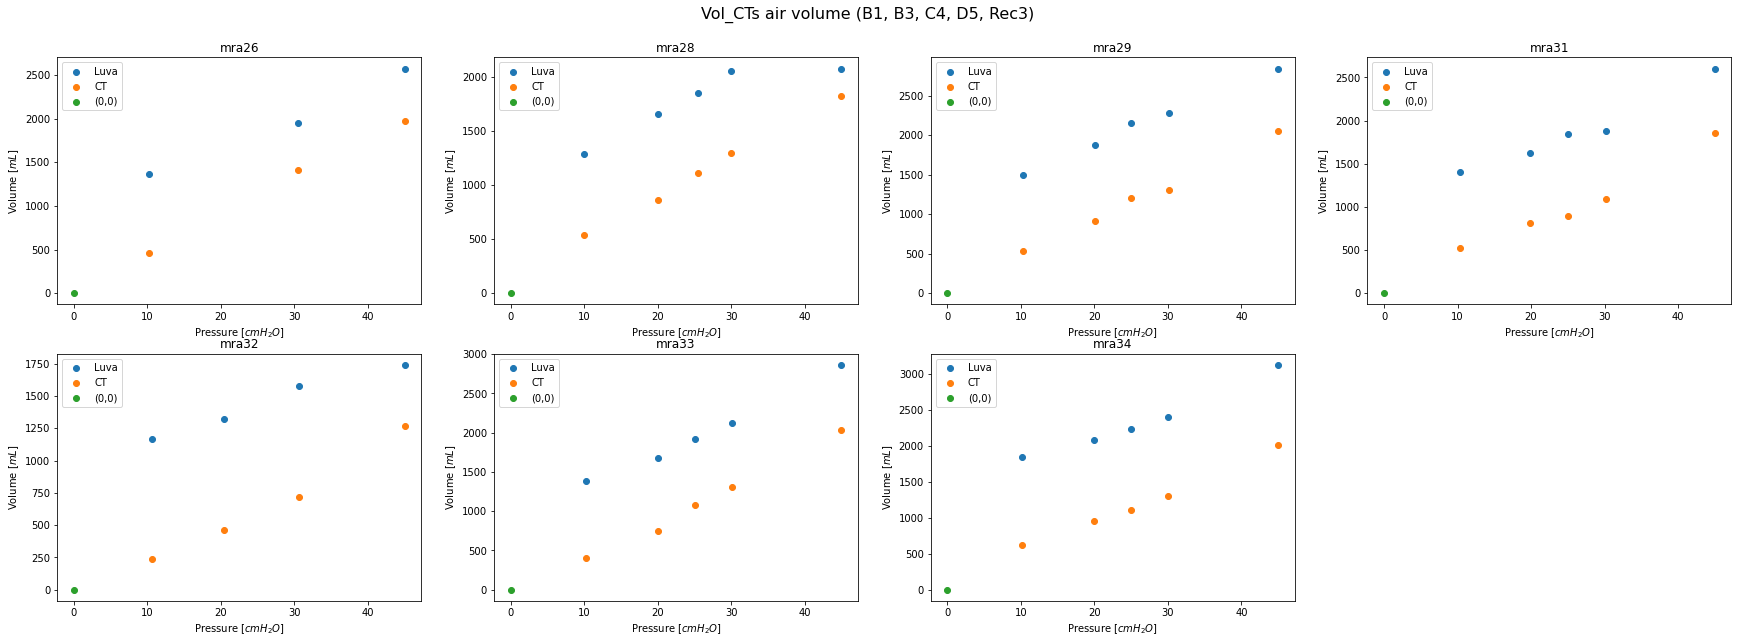

In [48]:
plt.subplots(figsize=(30, 10))
for idx in range(len(dados_ct_df)):
    p = dados_ct_df.iloc[idx]['Pressure']
    v = dados_ct_df.iloc[idx]['CT Volume']
    v_luva = dados_ct_df.iloc[idx]['Volume (Luva)']
    plt.subplot(2,4,idx+1)
    plt.scatter(p, v_luva,label='Luva')
    plt.scatter(p, v,label='CT')
    plt.scatter([0], [0],label='(0,0)')
    plt.legend()
    plt.xlabel('Pressure [$cmH_2O$]')
    plt.ylabel('Volume [$mL$]')
    plt.title(dados_ct_df.iloc[idx]['Animal'])
    plt.suptitle('Vol_CTs air volume (B1, B3, C4, D5, Rec3)', fontsize=16, y=0.95)